In [1]:
import numpy as np
import scipy.linalg as la
import scipy.stats as stats
import matplotlib.pyplot as plt

In [2]:
# Black-Scholes formula for European call and put options
def bs_call(S, K, T, r, q, sigma):
    d1 = (np.log(S/K) + (r - q + 0.5 * sigma ** 2) * T) / (sigma * np.sqrt(T))
    d2 = d1 - sigma * np.sqrt(T)
    return S * np.exp(-q * T) * stats.norm.cdf(d1) - K * np.exp(-r * T) * stats.norm.cdf(d2)

def bs_put(S, K, T, r, q, sigma):
    d1 = (np.log(S/K) + (r - q + 0.5 * sigma ** 2) * T) / (sigma * np.sqrt(T))
    d2 = d1 - sigma * np.sqrt(T)
    return K * np.exp(-r * T) * stats.norm.cdf(-d2) - S * np.exp(-q * T) * stats.norm.cdf(-d1)

In [3]:
def fdm_backward_explicit(T, sigma, r, q, K, S0, N, M, Smax, type = "call", american = False, greeks = False, return_grid = False):
    # Define payoff function
    if type == "call":
        def payoff(S):
            return np.maximum(S - K, 0)
    elif type == "put":
        def payoff(S):
            return np.maximum(K - S, 0)

    # Compute resolution
    dS = Smax / N
    dt = T / M
    
    # Check stability
    if dt > 1 / (sigma**2 * N**2):
        raise Warning("Finite difference method explicit condition unstable, try increase M or decrease N")
    
    # Initialise grid
    V = np.zeros((N + 1, M + 1))
    
    # Update maturity condition
    V[:, M] = payoff(np.arange(N + 1) * dS)
    
    # Compute supplement matrices
    n_vec = np.arange(0, N + 1)
    temp = sigma**2 * n_vec**2
    alpha = 0.5 * dt * (temp - (r - q) * n_vec)
    beta = 1 - dt * (temp + r)
    gamma = 0.5 * dt * (temp + (r - q) * n_vec)
    
    # Create tridiagonal matrix
    A = np.diag(alpha[1:], k = -1) + np.diag(beta) + np.diag(gamma[:-1], k = 1)
    A[N, N - 1] = alpha[-1] - gamma[-1]
    A[N, N] = beta[-1] + 2 * gamma[-1]
    
    # Update grid
    for m in range(M, 0, -1):
        # V[0, m - 1] = (1 - r * dt) * V[0, m] # Update lower boundary
        # V[1:N, m - 1] = alpha[1:N] * V[0:N - 1, m] + beta[1:N] * V[1:N, m] + gamma[1:N] * V[2:N + 1, m]
        # V[N, m - 1] = (alpha[N] - gamma[N]) * V[N - 1, m] + (beta[N] + 2 * gamma[N]) * V[N, m] # Update upper boundary

        # Use matrix multiplication to replace element-wise operations
        V[:, m - 1] = A @ V[:, m]
        if american:
            V[:, m - 1] = np.maximum(V[:, m - 1], payoff(n_vec * dS)) # For American options, check if early exercise is optimal
            
    # Return greeks
    if greeks:
        theta = np.concatenate([np.zeros((V.shape[0], 1)), V[:, 1:] - V[:, :-1]], axis=1) # This is correct
        delta = np.concatenate([np.zeros((1, V.shape[1])), V[1:, :] - V[:-1, :] / dS])
        gamma = np.concatenate([np.zeros((1, V.shape[1])), V[2:, :] - 2 * V[1:-1, :] + V[:-2, :] / dS**2]) # delta[1:, :] - delta[:-1, :] / dS is equivalent
        gamma = np.concatenate([gamma, np.zeros((1, V.shape[1]))], axis=0) # Pad the final row with zeros so that it has the same shape as V
        
        return (V, theta, delta, gamma) if return_grid else (V[int(S0 / dS), 0], theta[int(S0 / dS), 1], delta[int(S0 / dS), 0], gamma[int(S0 / dS), 0])
    
    return V if return_grid else V[int(S0 / dS), 0]

In [4]:
def fdm_backward_implicit(T, sigma, r, q, K, S0, N, M, Smax, type = "call", american = False, greeks = False, return_grid = False):
    # Define payoff function
    if type == "call":
        def payoff(S):
            return np.maximum(S - K, 0)
    elif type == "put":
        def payoff(S):
            return np.maximum(K - S, 0)

    # Compute resolution
    dS = Smax / N
    dt = T / M
    
    # Compute supplement matrices
    n_vec = np.arange(0, N + 1)
    temp = sigma**2 * n_vec**2
    a = -0.5 * dt * (temp - (r - q) * n_vec)
    b = 1 + dt * (temp + r)
    c = -0.5 * dt * (temp + (r - q) * n_vec)

    # Create the tridiagonal matrix
    A = np.diag(a[1:], k = -1) + np.diag(b) + np.diag(c[:-1], k = 1)
    A[N, N - 1] = N * (r - q) * dt # a_N
    A[N, N] = 1 - (N * (r - q) - r) * dt # b_N
    
    # Re-represent band matrix A with stack of arrays for scipy.linalg.solve_banded to accelerate the solving process
    diagonals = np.vstack([
        np.r_[0, A.diagonal(1)], # Upper diagonal, first element is zero
        A.diagonal(),            # Main diagonal
        np.r_[A.diagonal(-1), 0] # Lower diagonal, last element is zero
    ])

    # Initialise grid and assign boundary values
    V = np.zeros((N + 1, M + 1))
    V[:, M] = payoff(np.linspace(0, Smax, N + 1))

    # Update grid
    for m in range(M, 0, -1):
        # V[:, m - 1] = np.linalg.solve(A, V[:, m]) # Depreciated, use solve_banded instead
        V[:, m - 1] = la.solve_banded((1, 1), diagonals, V[:, m])
        if american:
            V[:, m - 1] = np.maximum(V[:, m - 1], payoff(n_vec * dS)) # For American options
    
    # Return greeks
    if greeks:
        theta = np.concatenate([np.zeros((V.shape[0], 1)), (V[:, 1:] - V[:, :-1])], axis=1) # This is correct
        delta = np.concatenate([np.zeros((1, V.shape[1])), (V[1:, :] - V[:-1, :]) / (2 * dS)])
        gamma = np.concatenate([np.zeros((1, V.shape[1])), (V[2:, :] - 2 * V[1:-1, :] + V[:-2, :]) / dS**2]) # delta[1:, :] - delta[:-1, :] / dS is equivalent
        gamma = np.concatenate([gamma, np.zeros((1, V.shape[1]))], axis=0) # Pad the final row with zeros so that it has the same shape as V
        
        return (V, theta, delta, gamma) if return_grid else (V[int(S0 / dS), 0], theta[int(S0 / dS), 1], delta[int(S0 / dS), 0], gamma[int(S0 / dS), 0])
    
    return V if return_grid else V[int(S0 / dS), 0]

In [5]:
# Environment parameters
K = 100             # Strike price
T = 1               # Time to maturity
r = 0.05            # Risk-free rate
q = 0.00            # Dividend yield
sigma = 0.2         # Volatility
S0 = 100            # Initial stock price
Smax = 5 * K        # Maximum value for the stock price

# Grid resolution for explicit scheme
N_explicit = 500    # Number of steps in S
M_explicit = 20000  # Number of steps in t

# Grid resolution for implicit scheme
N_implicit = 5000   # Number of steps in S
M_implicit = 5000   # Number of steps in t

# Simulation and results
call_explicit = fdm_backward_explicit(T, sigma, r, q, K, S0, N_explicit, M_explicit, Smax, type = "call", american = False, greeks = False, return_grid = False)
put_explicit = fdm_backward_explicit(T, sigma, r, q, K, S0, N_explicit, M_explicit, Smax, type = "put", american = False, greeks = False, return_grid = False)
call_implicit = fdm_backward_implicit(T, sigma, r, q, K, S0, N_implicit, M_implicit, Smax, type = "call", american = False, greeks = False, return_grid = False)
put_implicit = fdm_backward_implicit(T, sigma, r, q, K, S0, N_implicit, M_implicit, Smax, type = "put", american = False, greeks = False, return_grid = False)

print(f"Call Explicit: {call_explicit:.5f}")
print(f"Call Implicit: {call_implicit:.5f}")
print(f"Put Explicit: {put_explicit:.5f}")
print(f"Put Implicit: {put_implicit:.5f}")
print(f"Black-Scholes: {bs_call(S0, K, T, r, q, sigma):.5f}")
print(f"Black-Scholes: {bs_put(S0, K, T, r, q, sigma):.5f}")

Call Explicit: 10.44816
Call Implicit: 10.45035
Put Explicit: 5.57110
Put Implicit: 5.57332
Black-Scholes: 10.45058
Black-Scholes: 5.57353


/var/folders/p6/smj7c6c1417csf_h79x5rk4h0000gn/T/ipykernel_77651/3390637644.py:3: RuntimeWarning: divide by zero encountered in log
  d1 = (np.log(S/K) + (r - q + 0.5 * sigma ** 2) * T) / (sigma * np.sqrt(T))
/var/folders/p6/smj7c6c1417csf_h79x5rk4h0000gn/T/ipykernel_77651/3390637644.py:8: RuntimeWarning: divide by zero encountered in log
  d1 = (np.log(S/K) + (r - q + 0.5 * sigma ** 2) * T) / (sigma * np.sqrt(T))


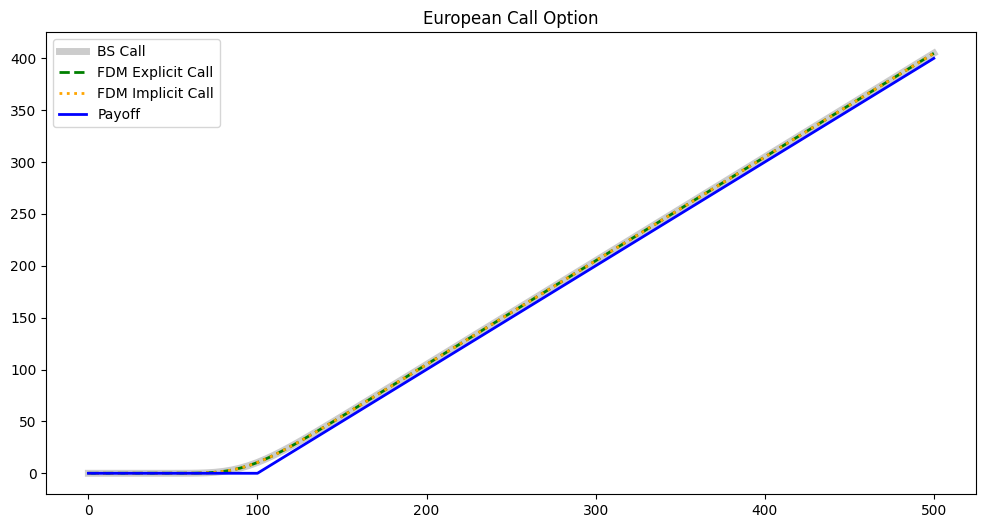

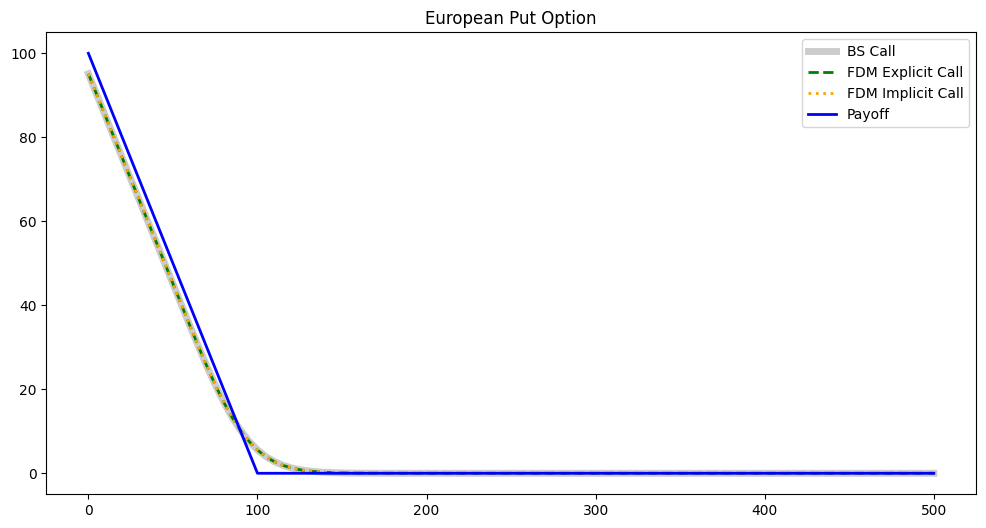

In [6]:
V_call_explicit = fdm_backward_explicit(T, sigma, r, q, K, S0, N_explicit, M_explicit, Smax, type = "call", american = False, greeks = False, return_grid = True)
V_put_explicit = fdm_backward_explicit(T, sigma, r, q, K, S0, N_explicit, M_explicit, Smax, type = "put", american = False, greeks = False, return_grid = True)
V_call_implicit = fdm_backward_implicit(T, sigma, r, q, K, S0, N_implicit, M_implicit, Smax, type = "call", american = False, greeks = False, return_grid = True)
V_put_implicit = fdm_backward_implicit(T, sigma, r, q, K, S0, N_implicit, M_implicit, Smax, type = "put", american = False, greeks = False, return_grid = True)

V_call_bs = bs_call(np.linspace(0, Smax, 100 + 1), K, T, r, q, sigma)
V_put_bs = bs_put(np.linspace(0, Smax, 100 + 1), K, T, r, q, sigma)

call_payoff = np.maximum(np.linspace(0, Smax, N_explicit + 1) - K, 0)
put_payoff = np.maximum(K - np.linspace(0, Smax, N_explicit + 1), 0)

plt.figure(figsize = (12, 6))
plt.plot(np.linspace(0, Smax, 100 + 1), V_call_bs, color = "gray", alpha = 0.4, lw = 5, label="BS Call")
plt.plot(np.linspace(0, Smax, N_explicit + 1), V_call_explicit[:, 0], color = "green", ls = "--", lw = 2, label="FDM Explicit Call")
plt.plot(np.linspace(0, Smax, N_implicit + 1), V_call_implicit[:, 0], color = "orange", ls = ":", lw = 2, label="FDM Implicit Call")
plt.plot(np.linspace(0, Smax, N_explicit + 1), call_payoff, color = "blue", ls = "-", lw = 2, label="Payoff")
plt.title("European Call Option")
plt.legend()
plt.show()

plt.figure(figsize = (12, 6))
plt.plot(np.linspace(0, Smax, 100 + 1), V_put_bs, color = "gray", alpha = 0.4, lw = 5, label="BS Call")
plt.plot(np.linspace(0, Smax, N_explicit + 1), V_put_explicit[:, 0], color = "green", ls = "--", lw = 2, label="FDM Explicit Call")
plt.plot(np.linspace(0, Smax, N_implicit + 1), V_put_implicit[:, 0], color = "orange", ls = ":", lw = 2, label="FDM Implicit Call")
plt.plot(np.linspace(0, Smax, N_explicit + 1), put_payoff, color = "blue", ls = "-", lw = 2, label="Payoff")
plt.title("European Put Option")
plt.legend()
plt.show()

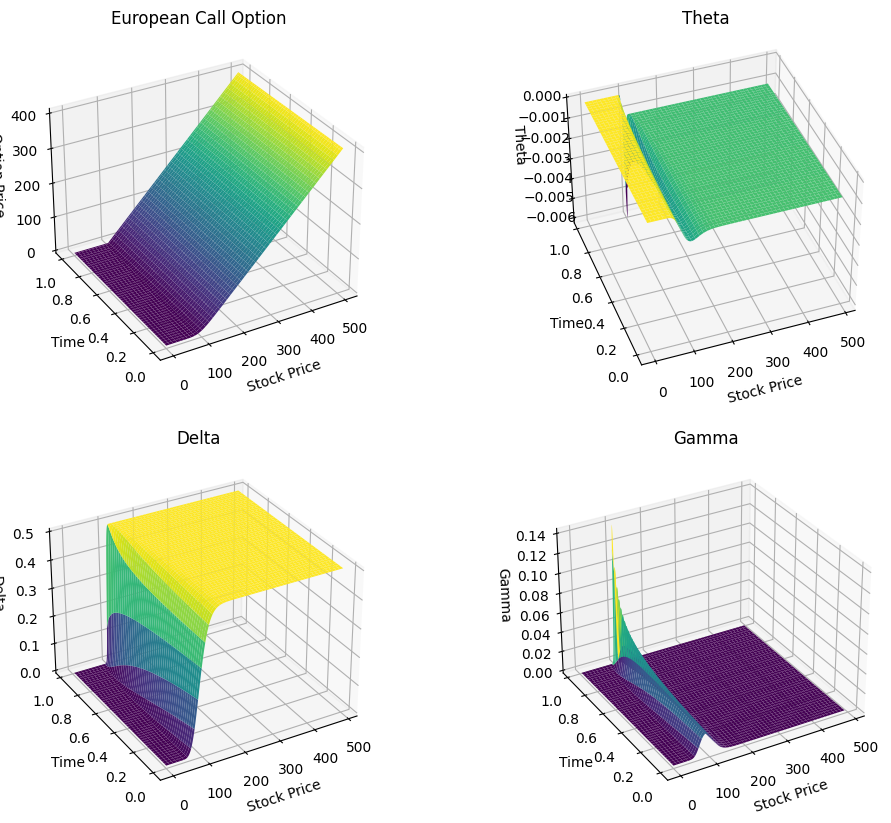

In [7]:
result = fdm_backward_implicit(
    T = 1,
    sigma = 0.2,
    r = 0.05,
    q = 0.00,
    K = 100,
    S0 = 100,
    N = 5000,
    M = 5000,
    Smax = 500,
    type = "call",
    american = False,
    greeks = True,
    return_grid = True
)

V = result[0]
theta = result[1]
delta = result[2]
gamma = result[3]

# Create the figure and axes
fig = plt.figure(figsize=(12, 10))
ax1 = fig.add_subplot(221, projection='3d') # 221 means 2x2 grid, first subplot
ax2 = fig.add_subplot(222, projection='3d') # 222 means 2x2 grid, second subplot
ax3 = fig.add_subplot(223, projection='3d') # 223 means 2x2 grid, third subplot
ax4 = fig.add_subplot(224, projection='3d') # 224 means 2x2 grid, fourth subplot

# Create the mesh grid
s_grid = np.linspace(0, Smax, N_implicit + 1)
t_grid = np.linspace(0, T, M_implicit + 1)
X, Y = np.meshgrid(s_grid, t_grid)

# Plot the option value
ax1.plot_surface(X, Y, V.T, cmap='viridis')
ax1.set_title('European Call Option')
ax1.set_xlabel('Stock Price')
ax1.set_ylabel('Time')
ax1.set_zlabel('Option Price')
ax1.view_init(30, -120)

# Plot the theta
ax2.plot_surface(X[1:-100, 1:-100], Y[1:-100, 1:-100], theta.T[1:-100, 1:-100], cmap='viridis')
ax2.set_title('Theta')
ax2.set_xlabel('Stock Price')
ax2.set_ylabel('Time')
ax2.set_zlabel('Theta')
ax2.view_init(40, -110)

# Plot the delta
ax3.plot_surface(X[1:-100, 1:-100], Y[1:-100, 1:-100], delta.T[1:-100, 1:-100], cmap='viridis')
ax3.set_title('Delta')
ax3.set_xlabel('Stock Price')
ax3.set_ylabel('Time')
ax3.set_zlabel('Delta')
ax3.view_init(30, -120)

# Plot the gamma
ax4.plot_surface(X[1:-100, 1:-100], Y[1:-100, 1:-100], gamma.T[1:-100, 1:-100], cmap='viridis')
ax4.set_title('Gamma')
ax4.set_xlabel('Stock Price')
ax4.set_ylabel('Time')
ax4.set_zlabel('Gamma')
ax4.view_init(30, -120)

plt.show()
